In [334]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Create Directory and Add Science Styles
plt.style.use(['science', 'ieee'])
plt.rcParams["text.usetex"] = False
plt.rcParams['figure.figsize'] = 6, 2
os.makedirs('plots', exist_ok=True)

# Window Size

In [335]:
ae_w_f1 = [0.995, 0.994, 0.9945, 0.9947]
usad_w_f1 = [0.9925, 0.9948, 0.9960, 0.9955]
dagmm_w_f1 = [None, 0.9935, 0.9952, 0.9948]
madgan_w_f1 = [None, None, 0.9957, 0.9950]
flae_w_f1 = [0.9945, 0.9930, 0.9957, 0.9933]

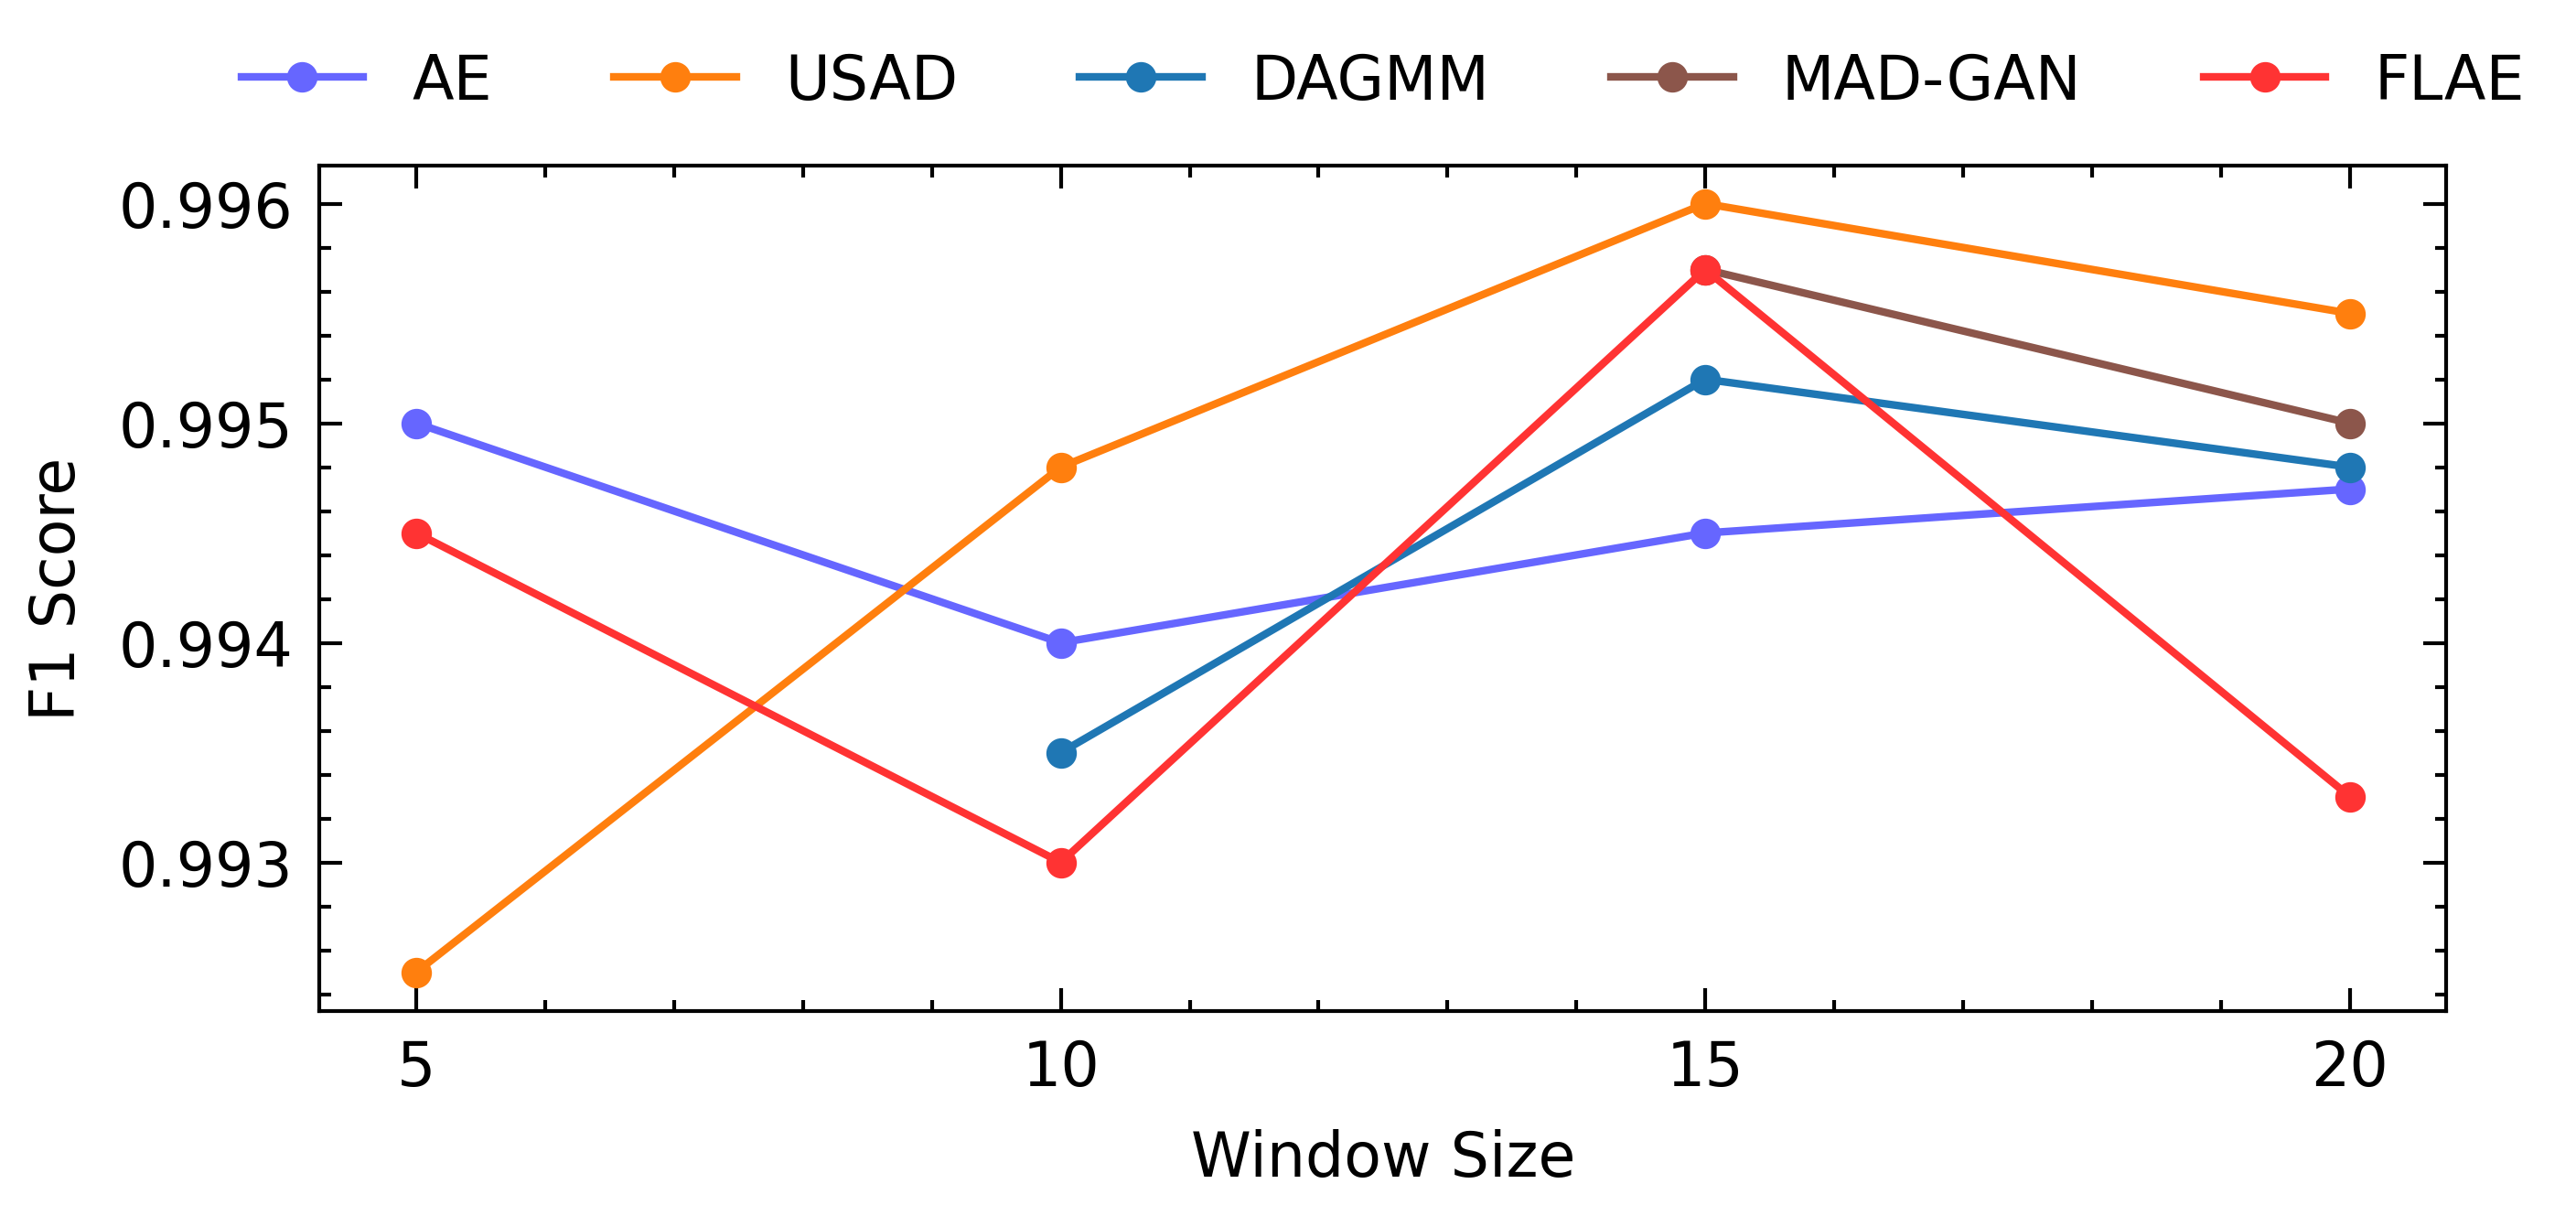

In [336]:
plt.figure(figsize=(5, 2))
plt.plot(ae_w_f1, color='#6666ff', marker='.', linestyle='-', label='AE')
plt.plot(usad_w_f1, color='#ff7f0e', marker='.', linestyle='-', label='USAD')
plt.plot(dagmm_w_f1, color='#1f77b4', marker='.', linestyle='-', label='DAGMM')
plt.plot(madgan_w_f1, color='#8c564b', marker='.', linestyle='-', label='MAD-GAN')
plt.plot(flae_w_f1, color='#ff3333', marker='.', linestyle='-', label='FLAE')
plt.xticks(range(4), [5, 10, 15, 20])
plt.xlabel('Window Size')
plt.ylabel('F1 Score')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5)
plt.show()

In [337]:
ae_w_auc = [0.9978, 0.9974, 0.9976, 0.9977]
usad_w_auc = [0.9967, 0.9977, 0.9982, 0.9980]
dagmm_w_auc = [None, 0.9972, 0.9979, 0.9977]
madgan_w_auc = [None, None, 0.9981, 0.9978]
flae_w_auc = [0.9976, 0.9970, 0.9981, 0.9971]

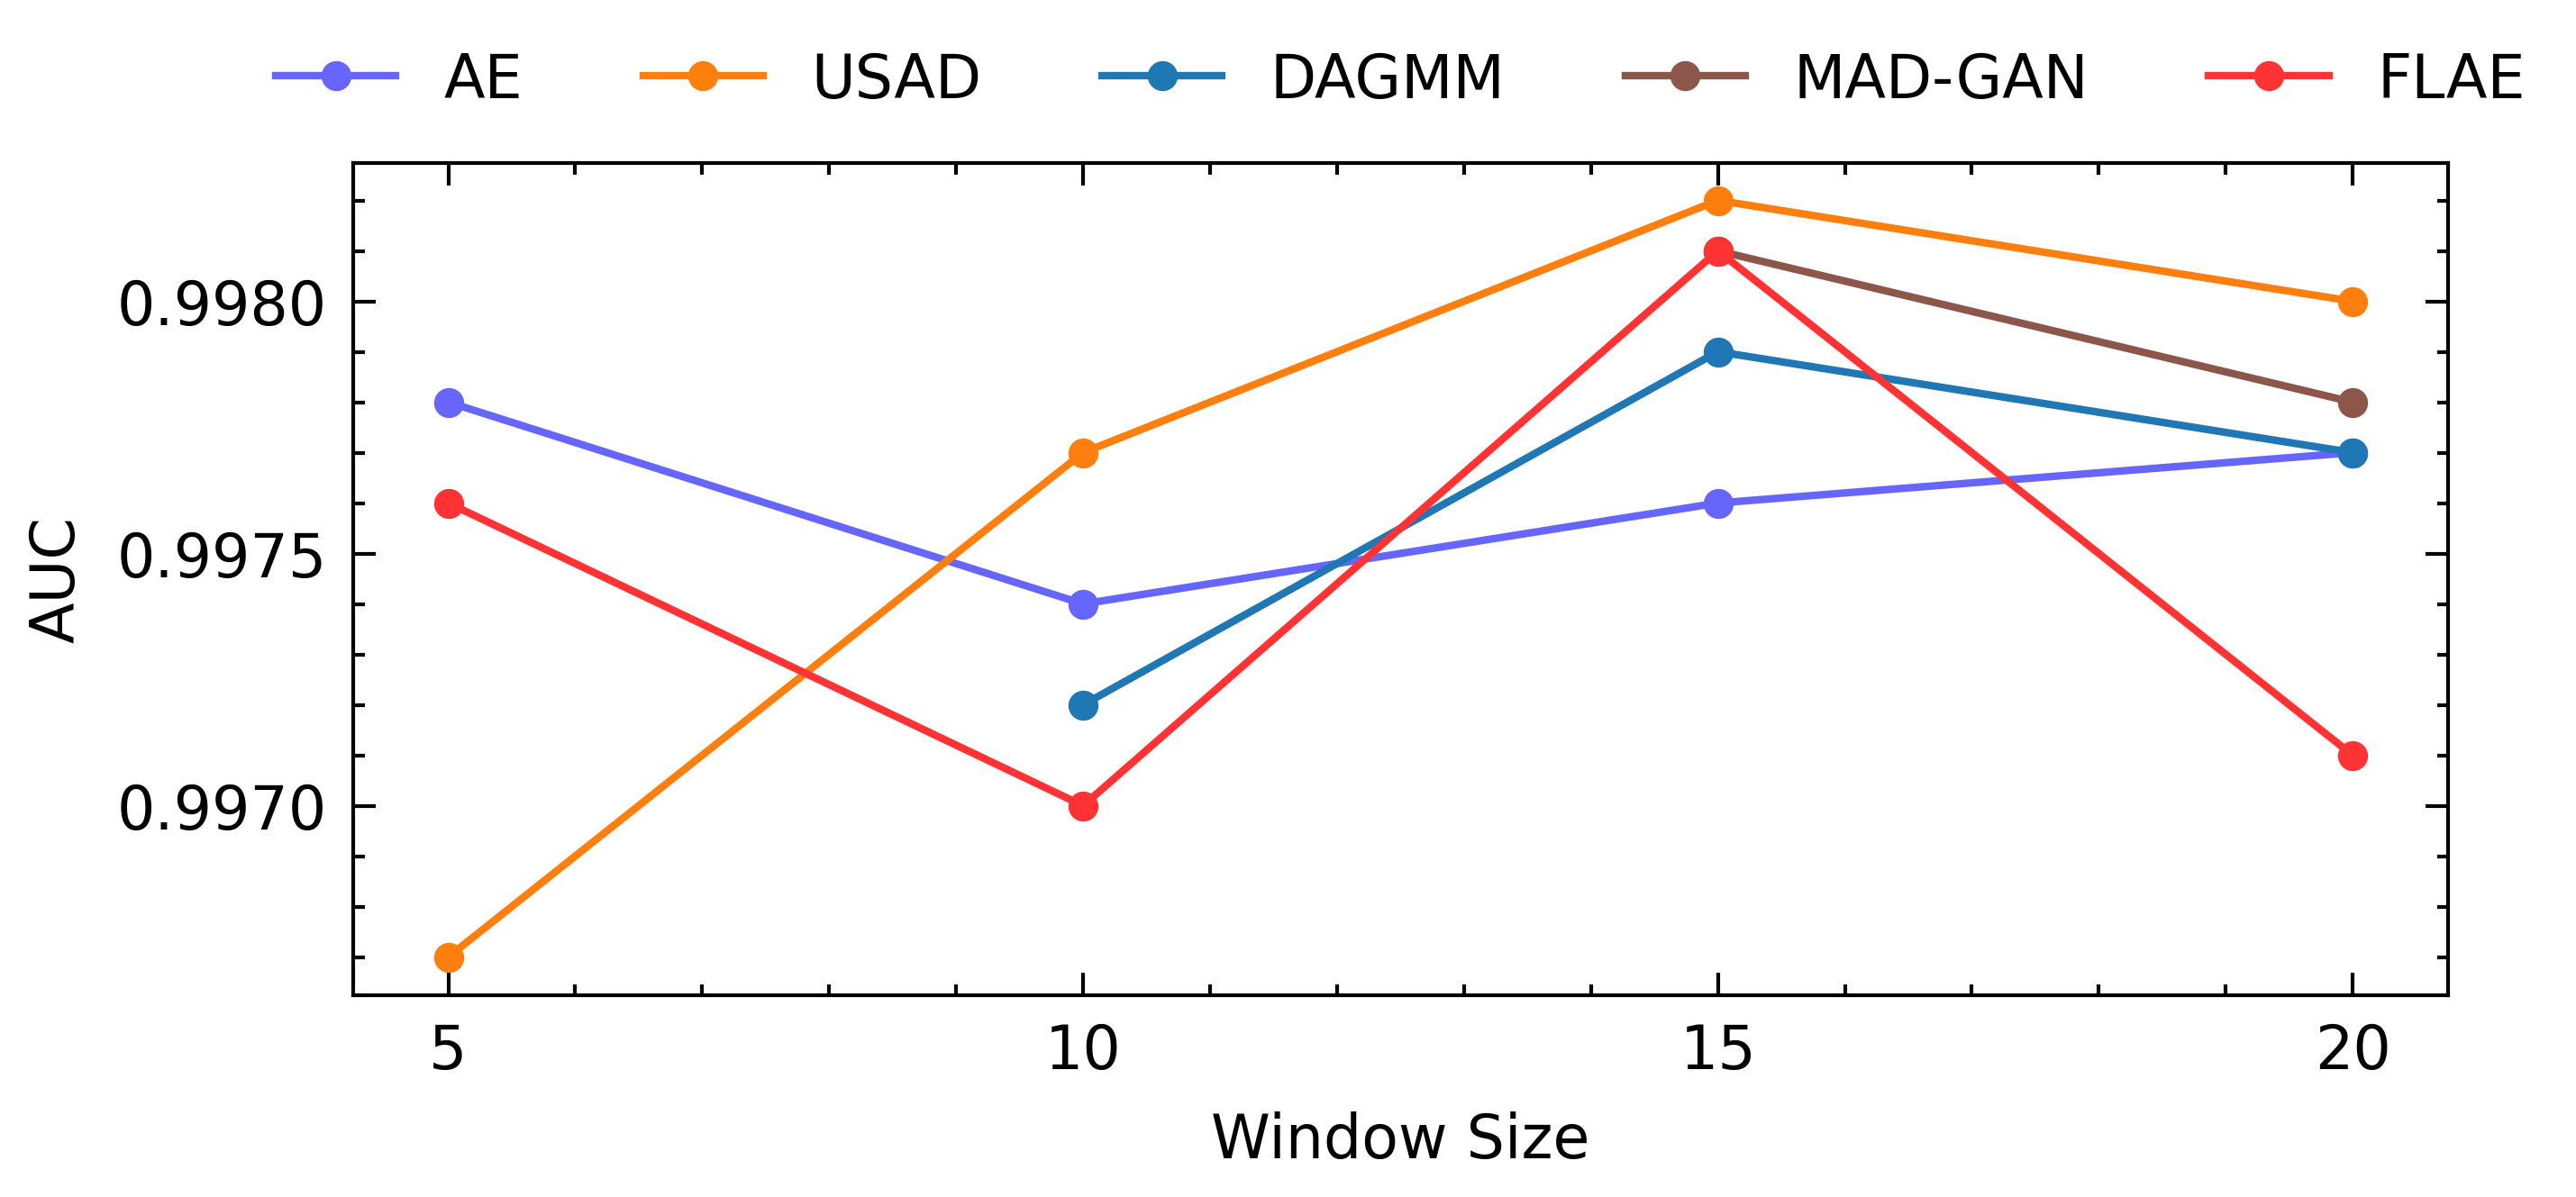

In [338]:
plt.figure(figsize=(5, 2))
plt.plot(ae_w_auc, color='#6666ff', marker='.', linestyle='-', label='AE')
plt.plot(usad_w_auc, color='#ff7f0e', marker='.', linestyle='-', label='USAD')
plt.plot(dagmm_w_auc, color='#1f77b4', marker='.', linestyle='-', label='DAGMM')
plt.plot(madgan_w_auc, color='#8c564b', marker='.', linestyle='-', label='MAD-GAN')
plt.plot(flae_w_auc, color='#ff3333', marker='.', linestyle='-', label='FLAE')
plt.xticks(range(4), [5, 10, 15, 20])
plt.xlabel('Window Size')
plt.ylabel('AUC')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5)
plt.show()

In [339]:
ae_w_time = [6.38, 7.38, 9.28, 12.55]
usad_w_time = [6.38, 7.38, 9.28, 12.55]
dagmm_w_time = [5.92, 5.98, 6, 7.85]
madgan_w_time = [9.67, 10.11, 9.37, 12.67]
flae_w_time = [2, 2.5, 4.95, 5.34]

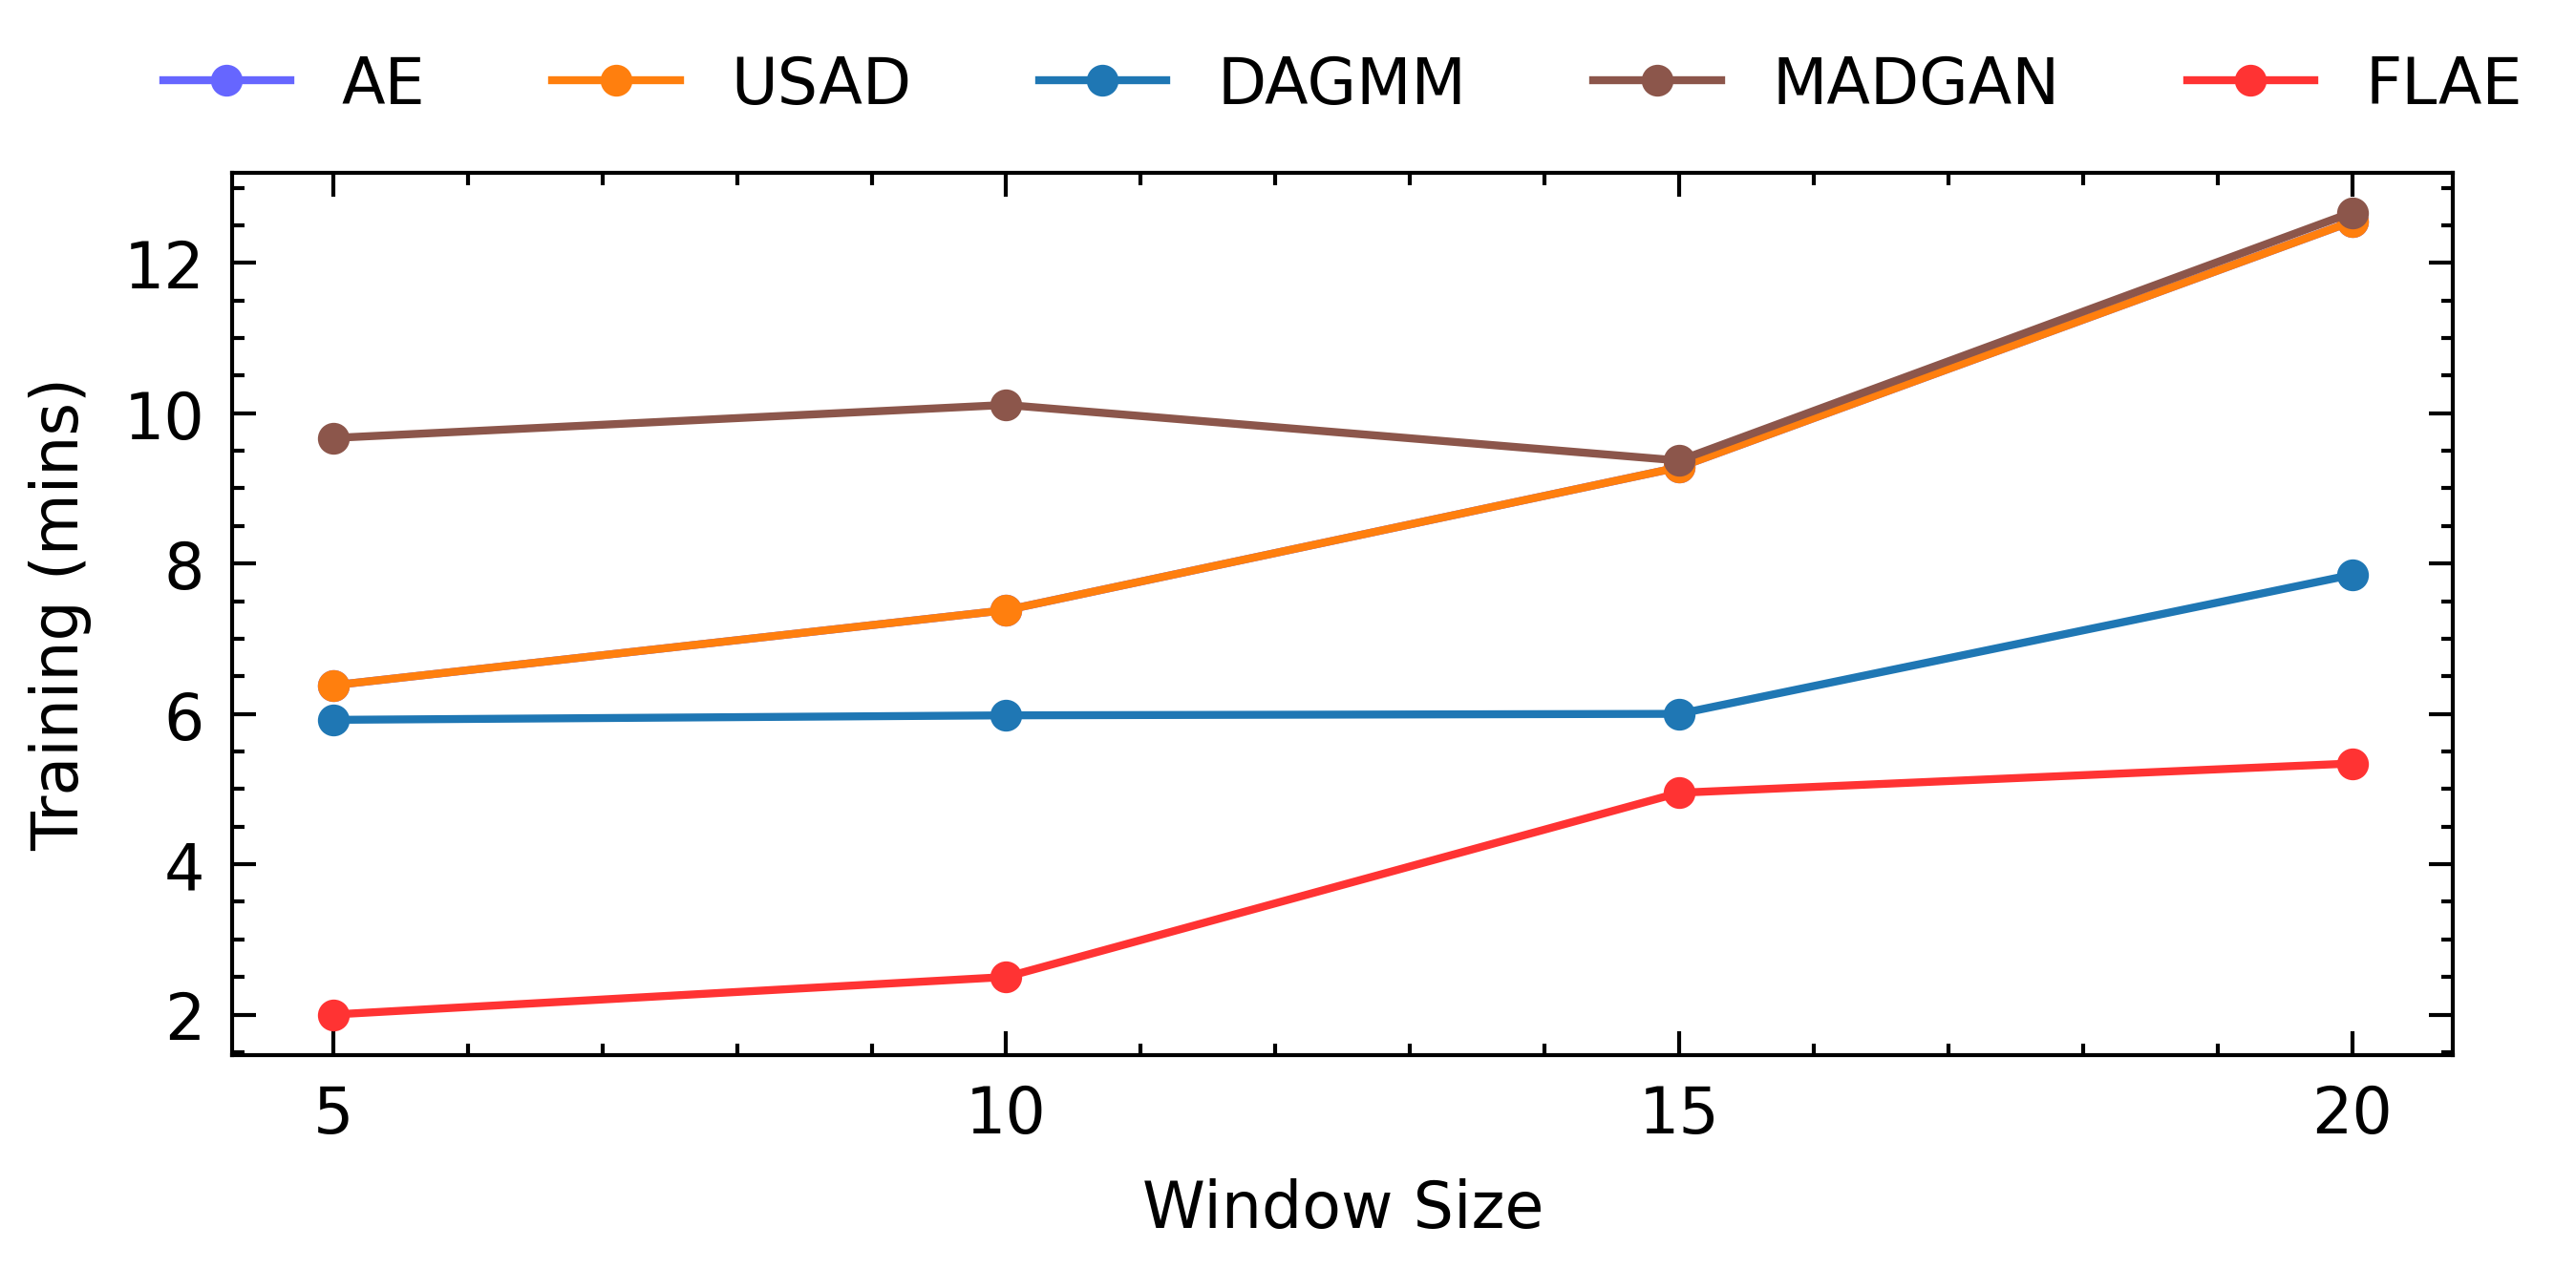

In [340]:
plt.figure(figsize=(5, 2))
plt.plot(ae_w_time, color='#6666ff', marker='.', linestyle='-', label='AE')
plt.plot(usad_w_time, color='#ff7f0e', marker='.', linestyle='-', label='USAD')
plt.plot(dagmm_w_time, color='#1f77b4', marker='.', linestyle='-', label='DAGMM')
plt.plot(madgan_w_time, color='#8c564b', marker='.', linestyle='-', label='MADGAN')
plt.plot(flae_w_time, color='#ff3333', marker='.', linestyle='-', label='FLAE')
plt.xticks(range(4), [5, 10, 15, 20])
plt.xlabel('Window Size')
plt.ylabel('Training (mins)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5)
plt.show()

# Dataset Ratio

In [341]:
ae_d_f1 = [0.2164, 0.5471, 0.9915, 0.9945]
usad_d_f1 = [0.7443, 0.4142, 0.9891, 0.9955]
dagmm_d_f1 = [0.8361, 0.4120, 0.9930, 0.9948]
madgan_d_f1 = [0.2159, 0.5506, 0.9890, 0.9950]
omni_d_f1 = [0.4076, 0.9901, 0.9923, 0.8446]
xticks = ['20%', '40%', '60%', '80%']

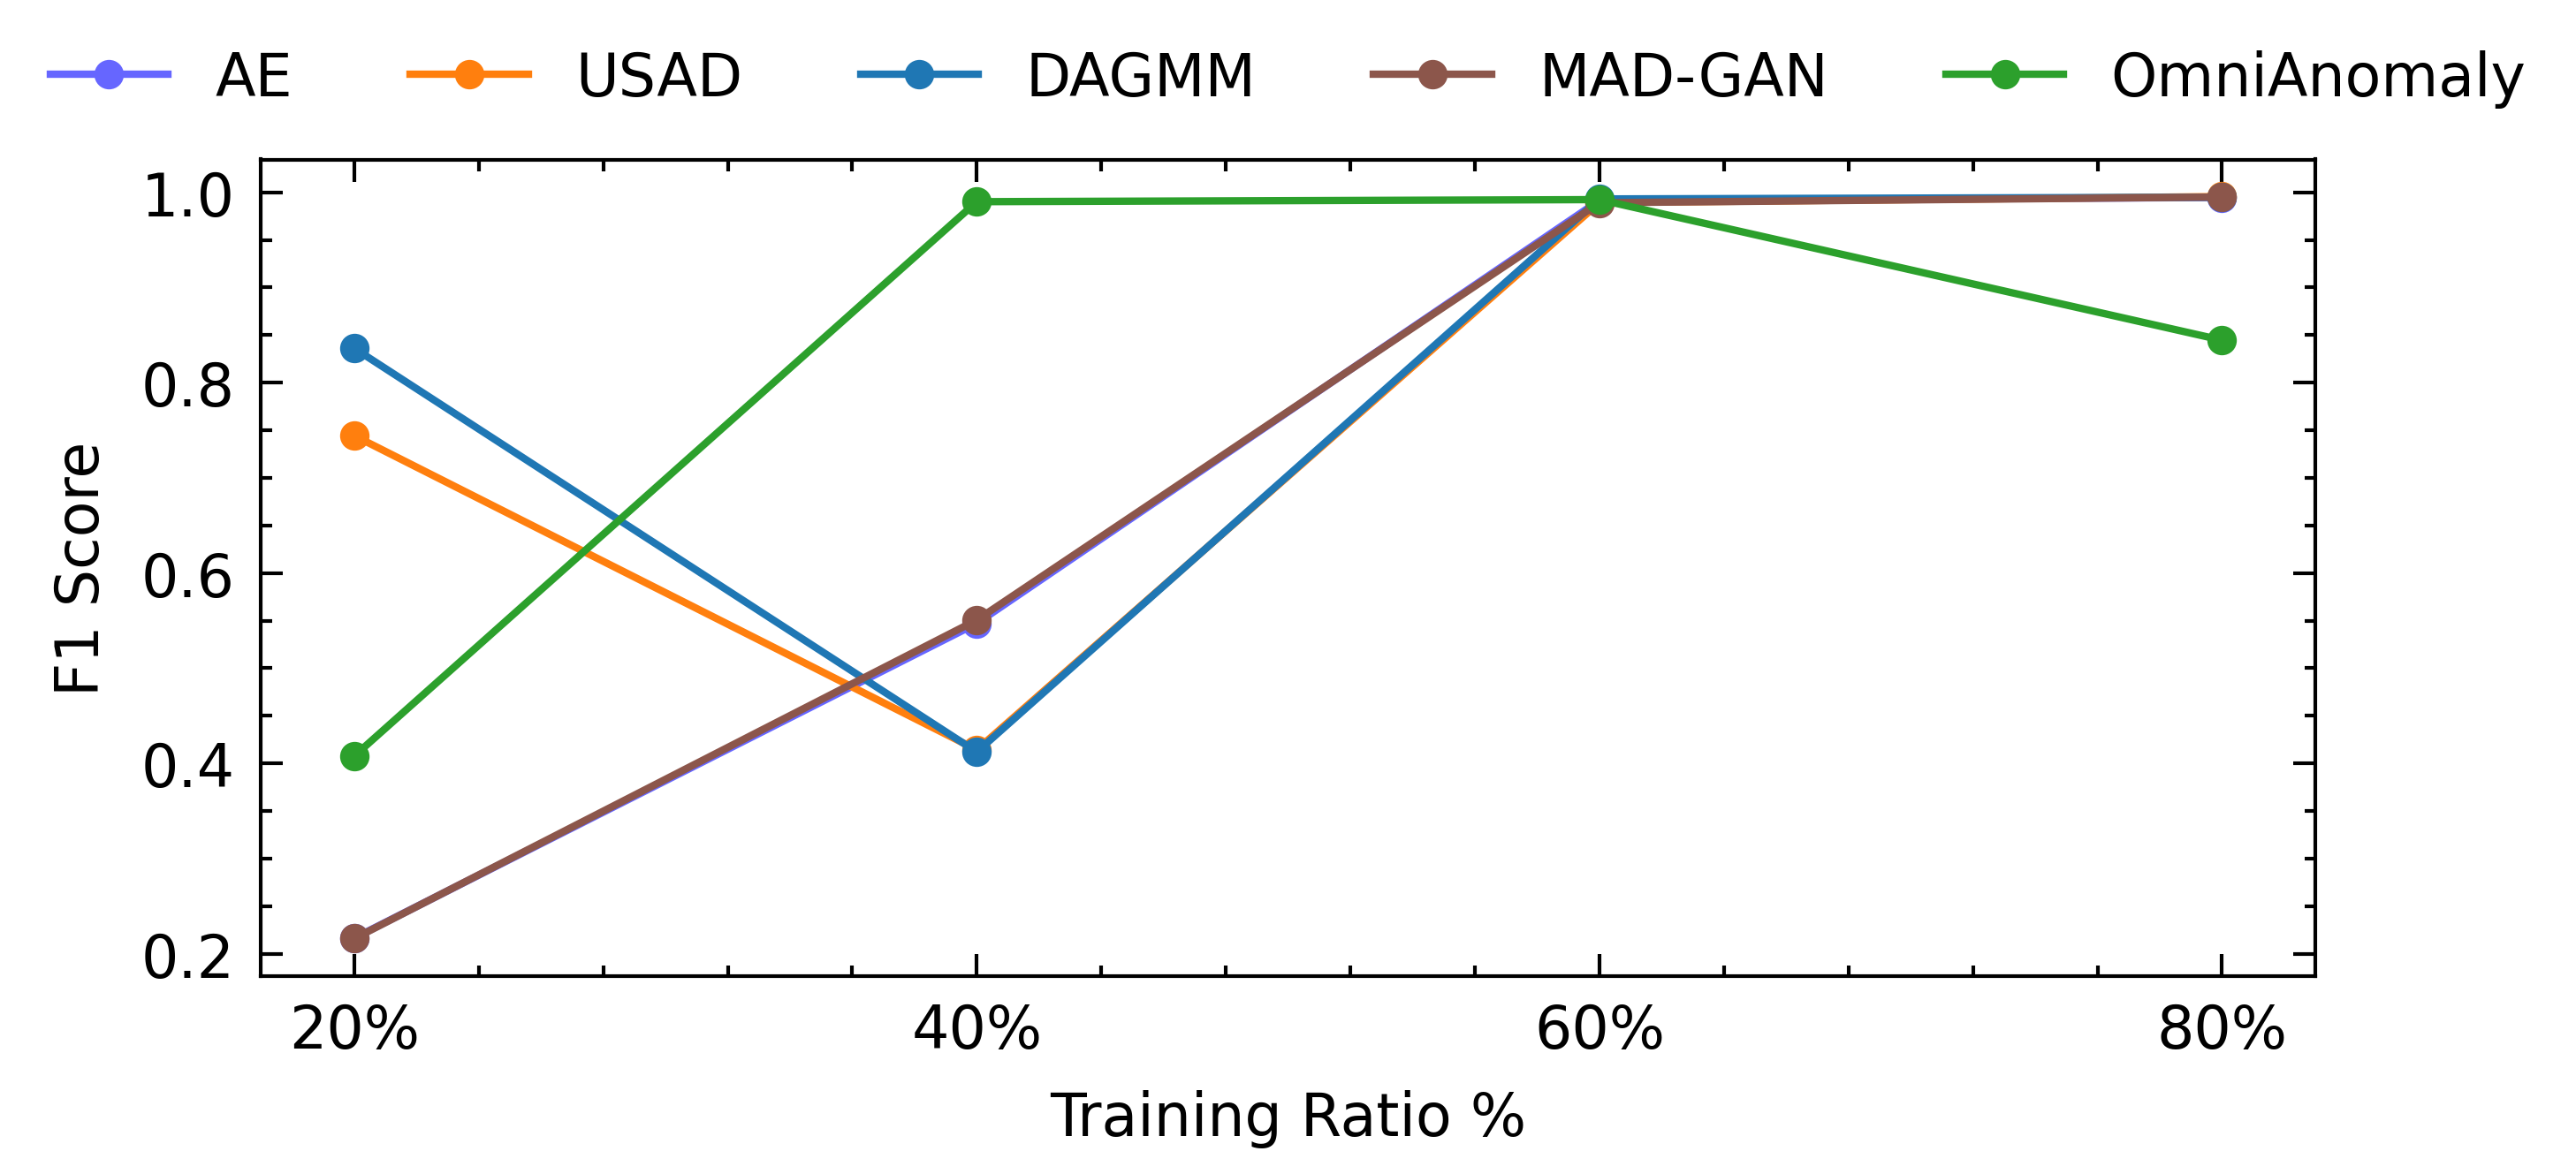

In [342]:
plt.figure(figsize=(5, 2))
plt.plot(ae_d_f1, color='#6666ff', marker='.', linestyle='-', label='AE')
plt.plot(usad_d_f1, color='#ff7f0e', marker='.', linestyle='-', label='USAD')
plt.plot(dagmm_d_f1, color='#1f77b4', marker='.', linestyle='-', label='DAGMM')
plt.plot(madgan_d_f1, color='#8c564b', marker='.', linestyle='-', label='MAD-GAN')
plt.plot(omni_d_f1, color='#2ca02c', marker='.', linestyle='-', label='OmniAnomaly')
plt.xticks(range(len(xticks)), xticks)
plt.xlabel('Training Ratio %')
plt.ylabel('F1 Score')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5)
plt.show()

In [343]:
ae_d_auc = [0.5611, 0.6914, 0.9983, 0.9976]
usad_d_auc = [0.8056, 0.6306, 0.998, 0.9982]
dagmm_d_auc = [0.868, 0.6303, 0.9986, 0.998]
madgan_d_auc = [0.5610, 0.6919, 0.9978, 0.9950]
omni_d_auc = [0.6298, 0.9986, 0.9984, 0.8670]
xticks = ['20%', '40%', '60%', '80%']

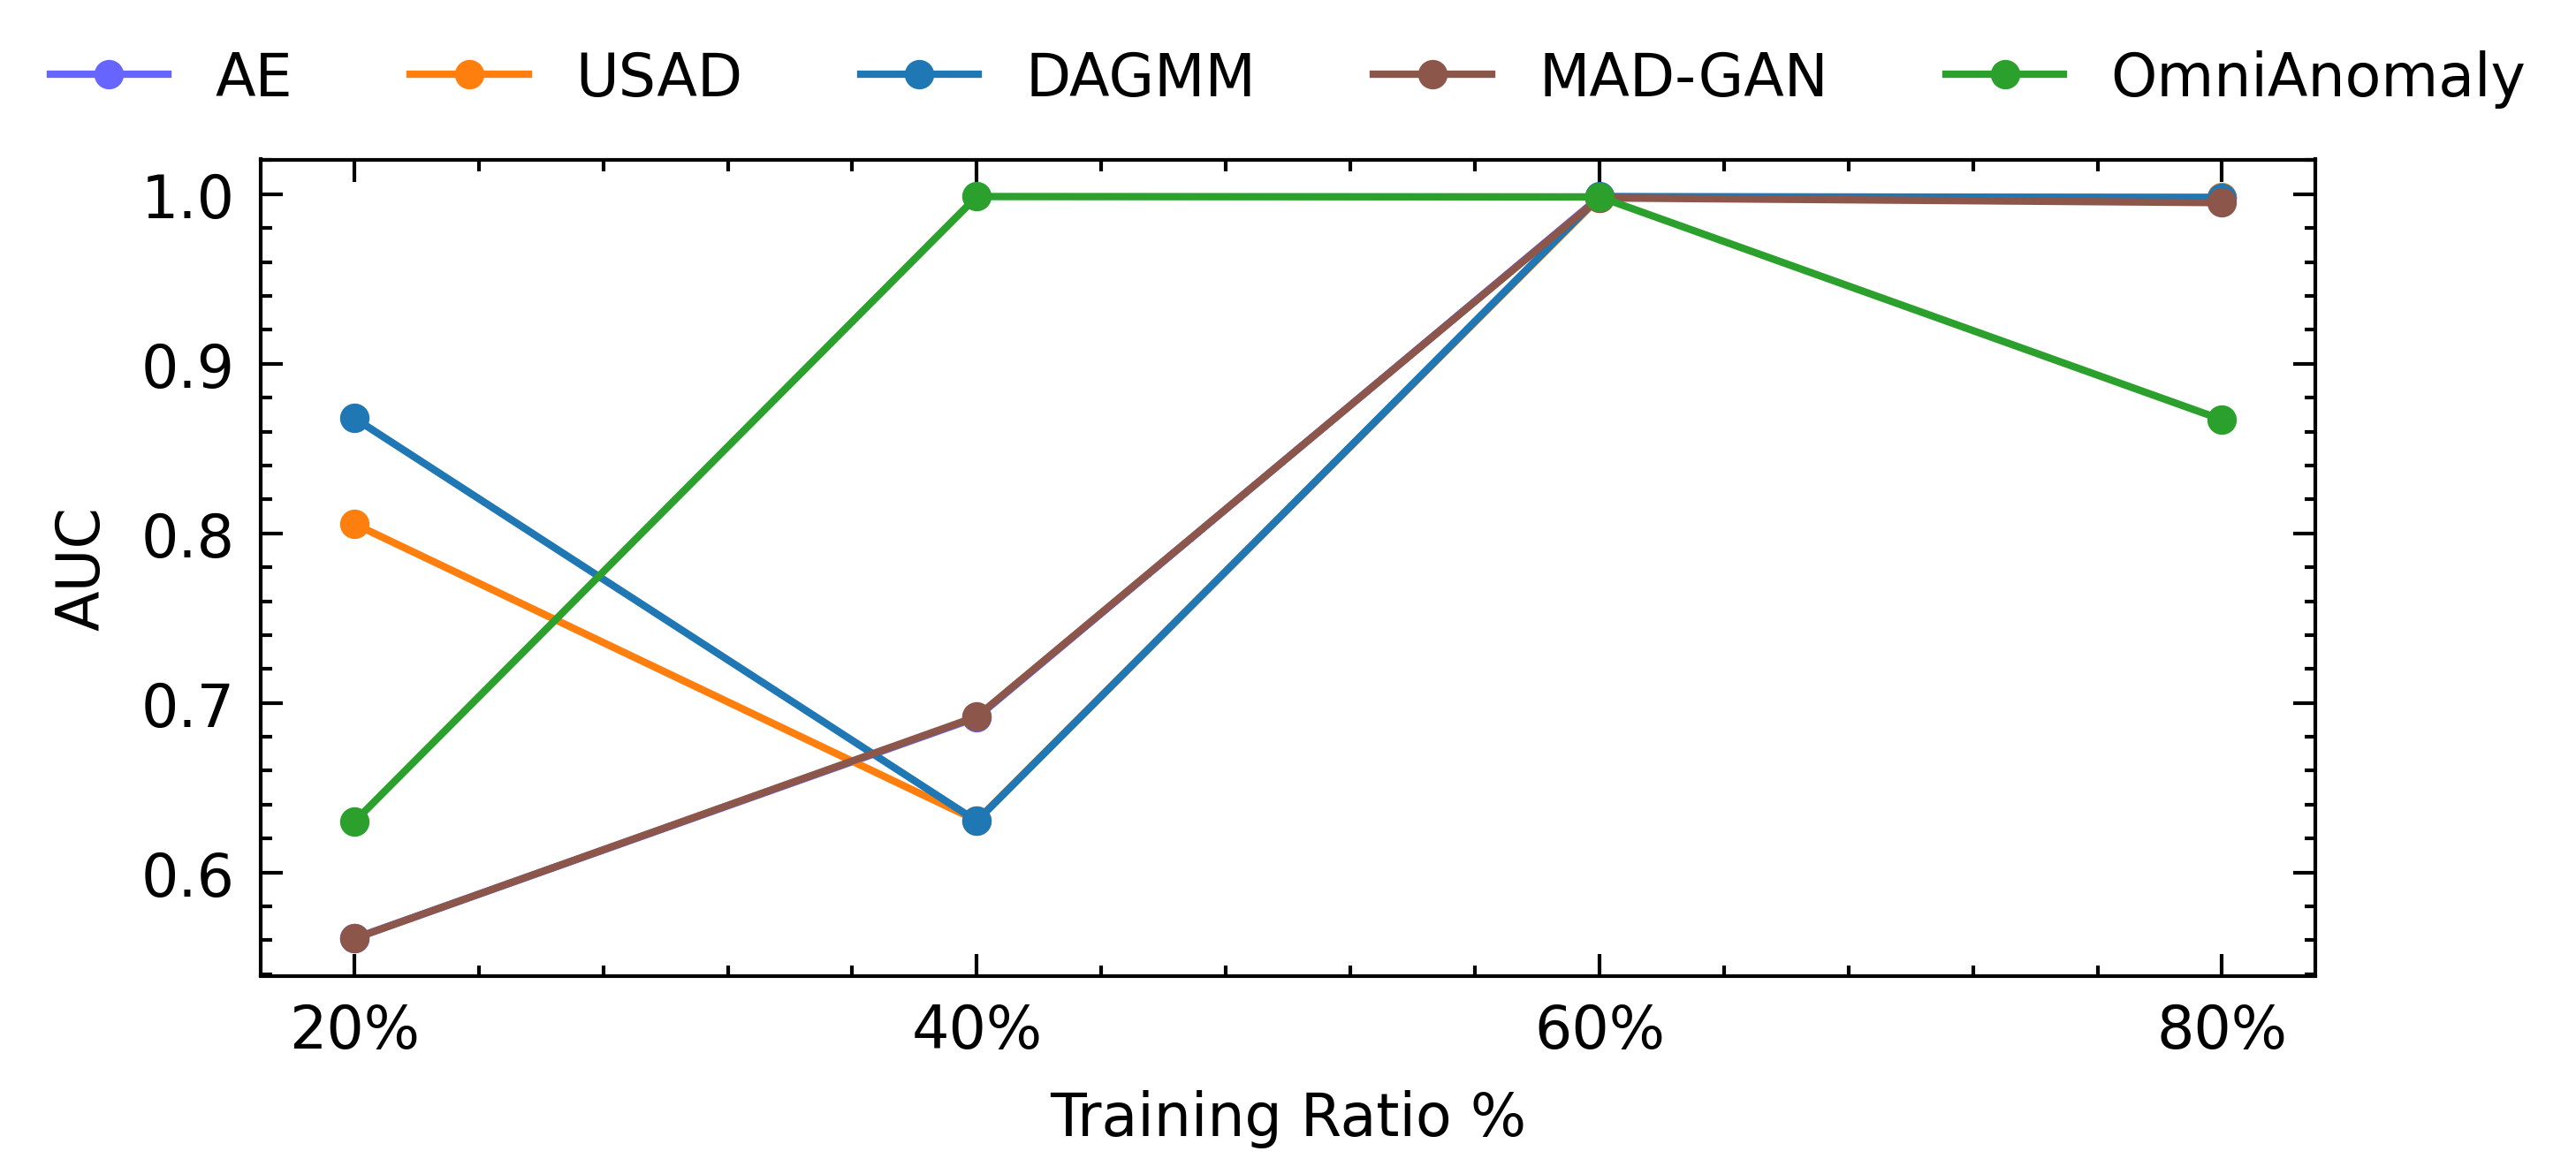

In [344]:
plt.figure(figsize=(5, 2))
plt.plot(ae_d_auc, color='#6666FF', marker='.', linestyle='-', label='AE')
plt.plot(usad_d_auc, color='#ff7f0e', marker='.', linestyle='-', label='USAD')
plt.plot(dagmm_d_auc, color='#1f77b4', marker='.', linestyle='-', label='DAGMM')
plt.plot(madgan_d_auc, color='#8c564b', marker='.', linestyle='-', label='MAD-GAN')
plt.plot(omni_d_auc, color='#2ca02c', marker='.', linestyle='-', label='OmniAnomaly')
plt.xticks(range(len(xticks)), xticks)
plt.xlabel('Training Ratio %')
plt.ylabel('AUC')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5)
plt.show()

In [345]:
ae_d_t = [1.9, 4.28, 6.15, 9.28]
usad_d_t = [2.38, 4.5, 7.05, 12.17]
dagmm_d_t = [1.6, 4.1, 6.2, 7.85]
madgan_d_t = [2.63, 5.38, 7.28, 9.37]
omni_d_t = [2.3, 6.83, 6.71, 11.38]

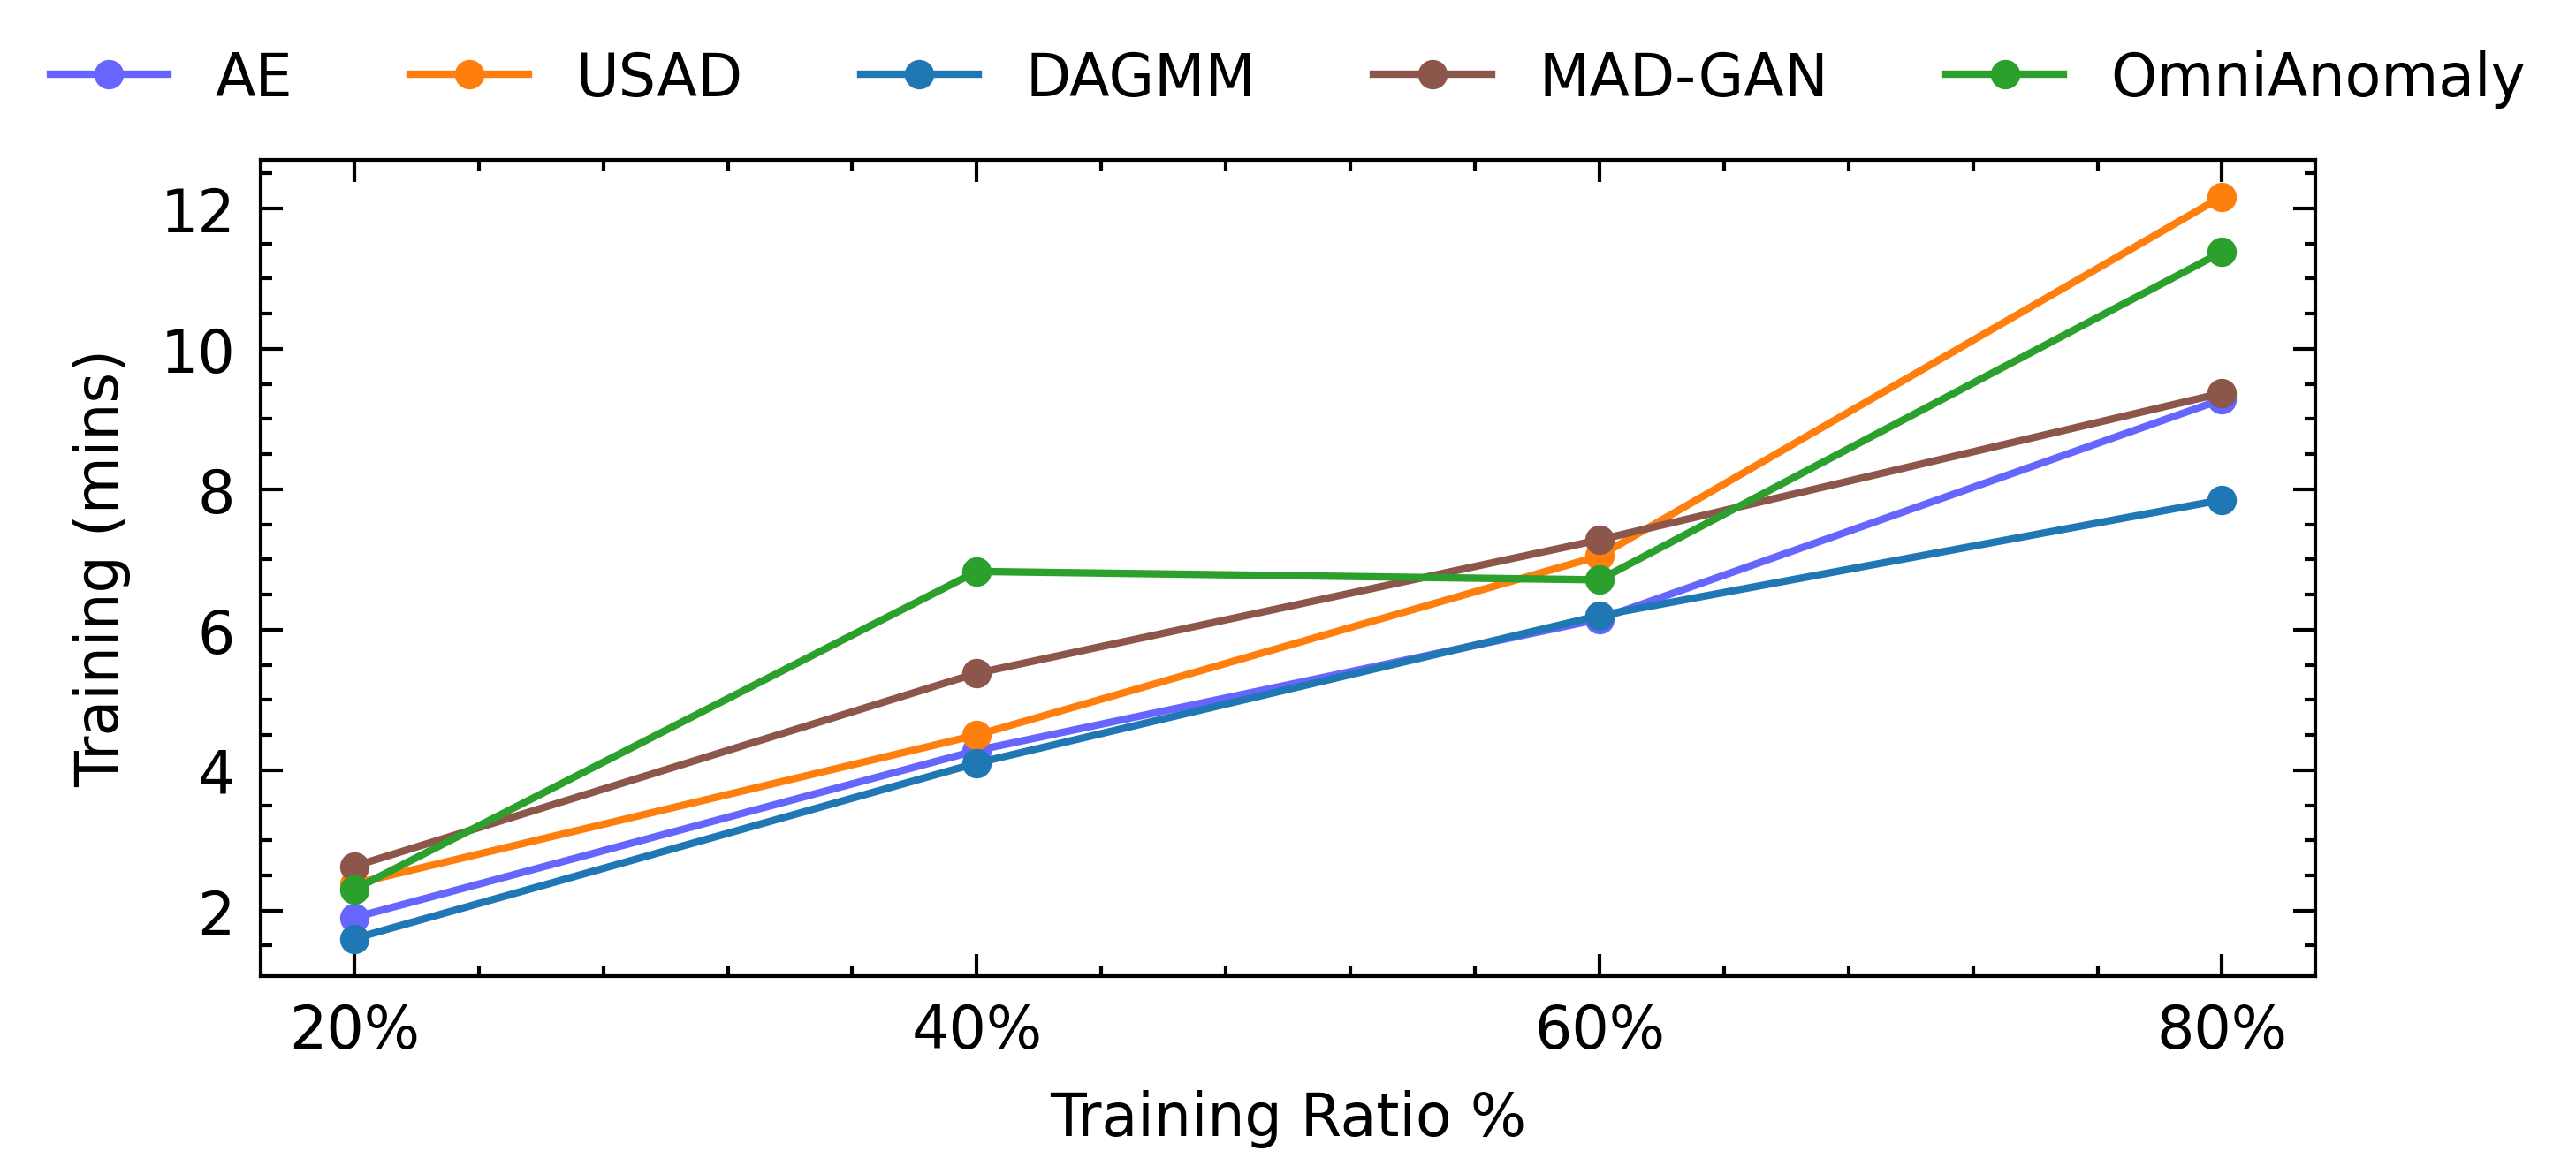

In [346]:
plt.figure(figsize=(5, 2))
plt.plot(ae_d_t, color='#6666FF', marker='.', linestyle='-', label='AE')
plt.plot(usad_d_t, color='#ff7f0e', marker='.', linestyle='-', label='USAD')
plt.plot(dagmm_d_t, color='#1f77b4', marker='.', linestyle='-', label='DAGMM')
plt.plot(madgan_d_t, color='#8c564b', marker='.', linestyle='-', label='MAD-GAN')
plt.plot(omni_d_t, color='#2ca02c', marker='.', linestyle='-', label='OmniAnomaly')
plt.xticks(range(len(xticks)), xticks)
plt.xlabel('Training Ratio %')
plt.ylabel('Training (mins)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=5)
plt.show()

In [347]:
loss_distributed = [(1, 0.021437036183973152), (2, 0.00651751544016103), (3, 0.005050786305218935), (4, 0.004173236045365532), (5, 0.003757134584399561), (6, 0.0034654449749117098), (7, 0.0033338172749305763), (8, 0.0032761211041361094), (9, 0.0032233954795325794), (10, 0.0031675274949520826), (11, 0.0031045120364675918), (12, 0.003025257804741462), (13, 0.002903664135374129), (14, 0.002839992637746036), (15, 0.0028044290374964476), (16, 0.002780696920429667), (17, 0.00276349737153699), (18, 0.0027506372037654123), (19, 0.002740984045279523), (20, 0.0027337957872077823)]
loss_centralized = [(1, 0.01337427037562604), (2, 0.01421115282615797), (3, 0.00927954634209689), (4, 0.00645253980053273), (5, 0.005530216954666373), (6, 0.005047562524364072), (7, 0.004788293636312039), (8, 0.004613939446514747), (9, 0.004419040920206025), (10, 0.004225863141464997), (11, 0.004057001644730495), (12, 0.003937456730499818), (13, 0.0038090054669783313), (14, 0.003733012284722993), (15, 0.0036914705031268866), (16, 0.003664153987549463), (17, 0.0036444159845258352), (18, 0.003629899834191642), (19, 0.0036190209565498135), (20, 0.0036103513794633886)]

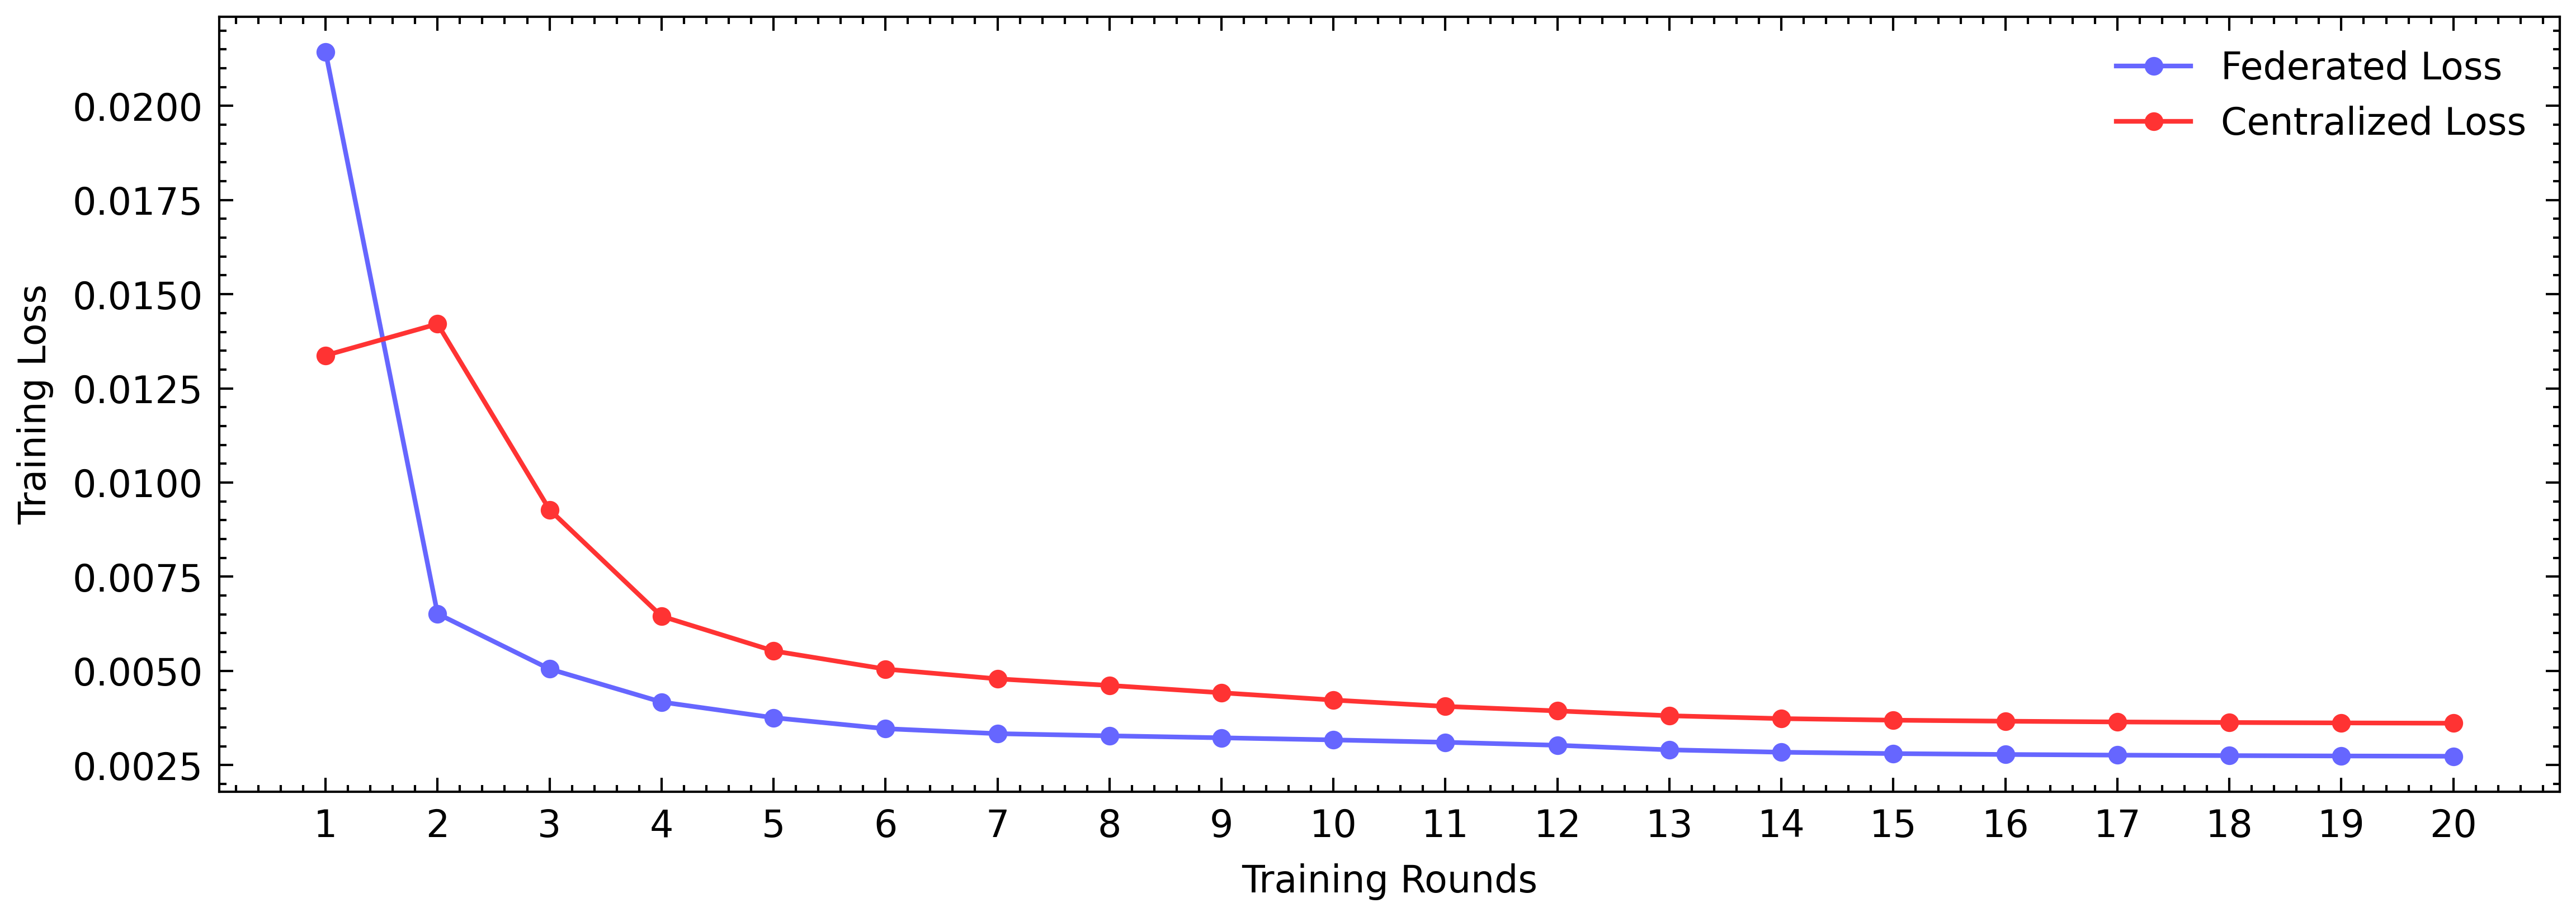

In [348]:
count = [i[0] for i in loss_distributed]
loss_dis = [i[1] for i in loss_distributed]
loss_cen = [i[1] for i in loss_centralized]
plt.figure(figsize=(9, 3))
plt.plot(loss_dis, color='#6666FF', marker='.', linestyle='-', label='Federated Loss')
plt.plot(loss_cen, color='#FF3333', marker='.', linestyle='-', label='Centralized Loss')
plt.xticks(range(len(count)), count)
plt.xlabel('Training Rounds')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

# Evaluation of each device

In [349]:
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import DataLoader
from codes.evaluations.eval_utils import *
from codes.plotter import *

config = {
    "num_epochs": 20,
    "learning_rate": 0.0001,
    "weight_decay": 1e-5,
    "num_window": 15,
}

In [350]:
def load_model(modelname, dims, config):
    import codes.models
    model_class = getattr(codes.models, modelname)
    model = model_class(dims, config).double()
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['learning_rate'], weight_decay=config['weight_decay'])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 5, 0.9)
    fname = f'checkpoints/FLAE_ENERGY/model.ckpt'
    if os.path.exists(fname):
        print(f"Loading pre-trained model: {model.name}")
        checkpoint = torch.load(fname)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        # accuracy_list = checkpoint['accuracy_list']
    return model, optimizer, scheduler

In [351]:
def load_dataset(dataset, cid, filter=True):
    if filter:
        folder = os.path.join(f'data/processed/{dataset}/filtered/{cid}')
    else:
        folder = os.path.join('data/processed', dataset)
    if not os.path.exists(folder):
        raise Exception('Processed Data not found.')
    loader = []
    for file in ['train', 'test', 'labels']:
        loader.append(np.load(os.path.join(folder, f'{file}.npy')))
    _train_loader = DataLoader(loader[0], batch_size=loader[0].shape[0])
    _test_loader = DataLoader(loader[1], batch_size=loader[1].shape[0])
    _labels = loader[2]
    return _train_loader, _test_loader, _labels

def convert_to_windows(data, model):
    windows = []
    w_size = model.n_window
    for i, _ in enumerate(data):
        if i >= w_size:
            w = data[i - w_size:i]
        else:
            w = torch.cat([data[0].repeat(w_size - i, 1), data[0:i]])
        windows.append(w.view(-1))
    return torch.stack(windows)

In [352]:
def backprop(epoch, model, data, dataO, optimizer, scheduler, training=True):
    l = nn.MSELoss(reduction='mean' if training else 'none')
    feats = dataO.shape[1]
    if 'AE' in model.name:
        l = nn.MSELoss(reduction = 'none')
        l1 = nn.L1Loss(reduction = 'none')
        n = epoch + 1
        l1s = []
        if training:
            for _, d in enumerate(data):
                x = model(d)
                loss = torch.mean(l(x, d))
                l1s.append(torch.mean(loss).item())
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            scheduler.step()
            tqdm.write(f'Epoch {epoch + 1},\tMSE = {np.mean(l1s)}')
            return np.mean(l1s), optimizer.param_groups[0]['lr']
        else:
            xs = []
            for d in data: 
                x = model(d)
                xs.append(x)
            xs = torch.stack(xs)
            y_pred = xs[:, data.shape[1]-feats:data.shape[1]].view(-1, feats)
            loss = l(xs, data)
            loss = loss[:, data.shape[1]-feats:data.shape[1]].view(-1, feats)
            mae = l1(xs, data)
            mae = mae[:, data.shape[1]-feats:data.shape[1]].view(-1, feats)
            return loss.detach().numpy(), mae.detach().numpy(), y_pred.detach().numpy()
    else:
        y_pred = model(data)
        loss = l(y_pred, data)
        if training:
            tqdm.write(f'Epoch {epoch},\tMSE = {loss}')
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            return loss.item(), optimizer.param_groups[0]['lr']
        else:
            return loss.detach().numpy(), y_pred.detach().numpy()
        

In [353]:
device = 'dev5'

In [354]:
train_loader, test_loader, labels = load_dataset('ENERGY', device, filter=True)
model, optimizer, scheduler = load_model('AE', labels.shape[1], config)
## Prepare data
trainD, testD = next(iter(train_loader)), next(iter(test_loader))
trainO, testO = trainD, testD
if model.name in ['AE']:
    trainD, testD = convert_to_windows(trainD, model), convert_to_windows(testD, model)
### Testing phase
torch.zero_grad = True
model.eval()
with torch.no_grad():
    loss, mae, y_pred = backprop(0, model, testD, testO, optimizer, scheduler, training=False)
    ### Scores
    plot_actual_predicted('FLAE_ENERGY', testO, y_pred)
    lossT, _, _ = backprop(0, model, trainD, trainO, optimizer, scheduler, training=False)
    for i in range(loss.shape[1]):
        lt, l, ls = lossT[:, i], loss[:, i], labels[:, i]
        result, _ = pot_eval(lt, l, ls)
        
    lossTfinal, lossFinal = np.mean(lossT, axis=1), np.mean(loss, axis=1)
    labelsFinal = (np.sum(labels, axis=1) >= 1) + 0
    
    result, _ = pot_eval(lossTfinal, lossFinal, labelsFinal)
    
    print(result)
    print("MAE: ", np.mean(mae))
    print("MSE: ", np.mean(loss))

{'f1': 0.0, 'precision': 0.0, 'recall': 0.0, 'TP': 0, 'TN': 2976, 'FP': 1, 'FN': 670, 'ROC/AUC': 0.4998320456835741, 'threshold': 0.5185185030358254}
MAE:  0.21855566109582547
MSE:  0.09241594503205544


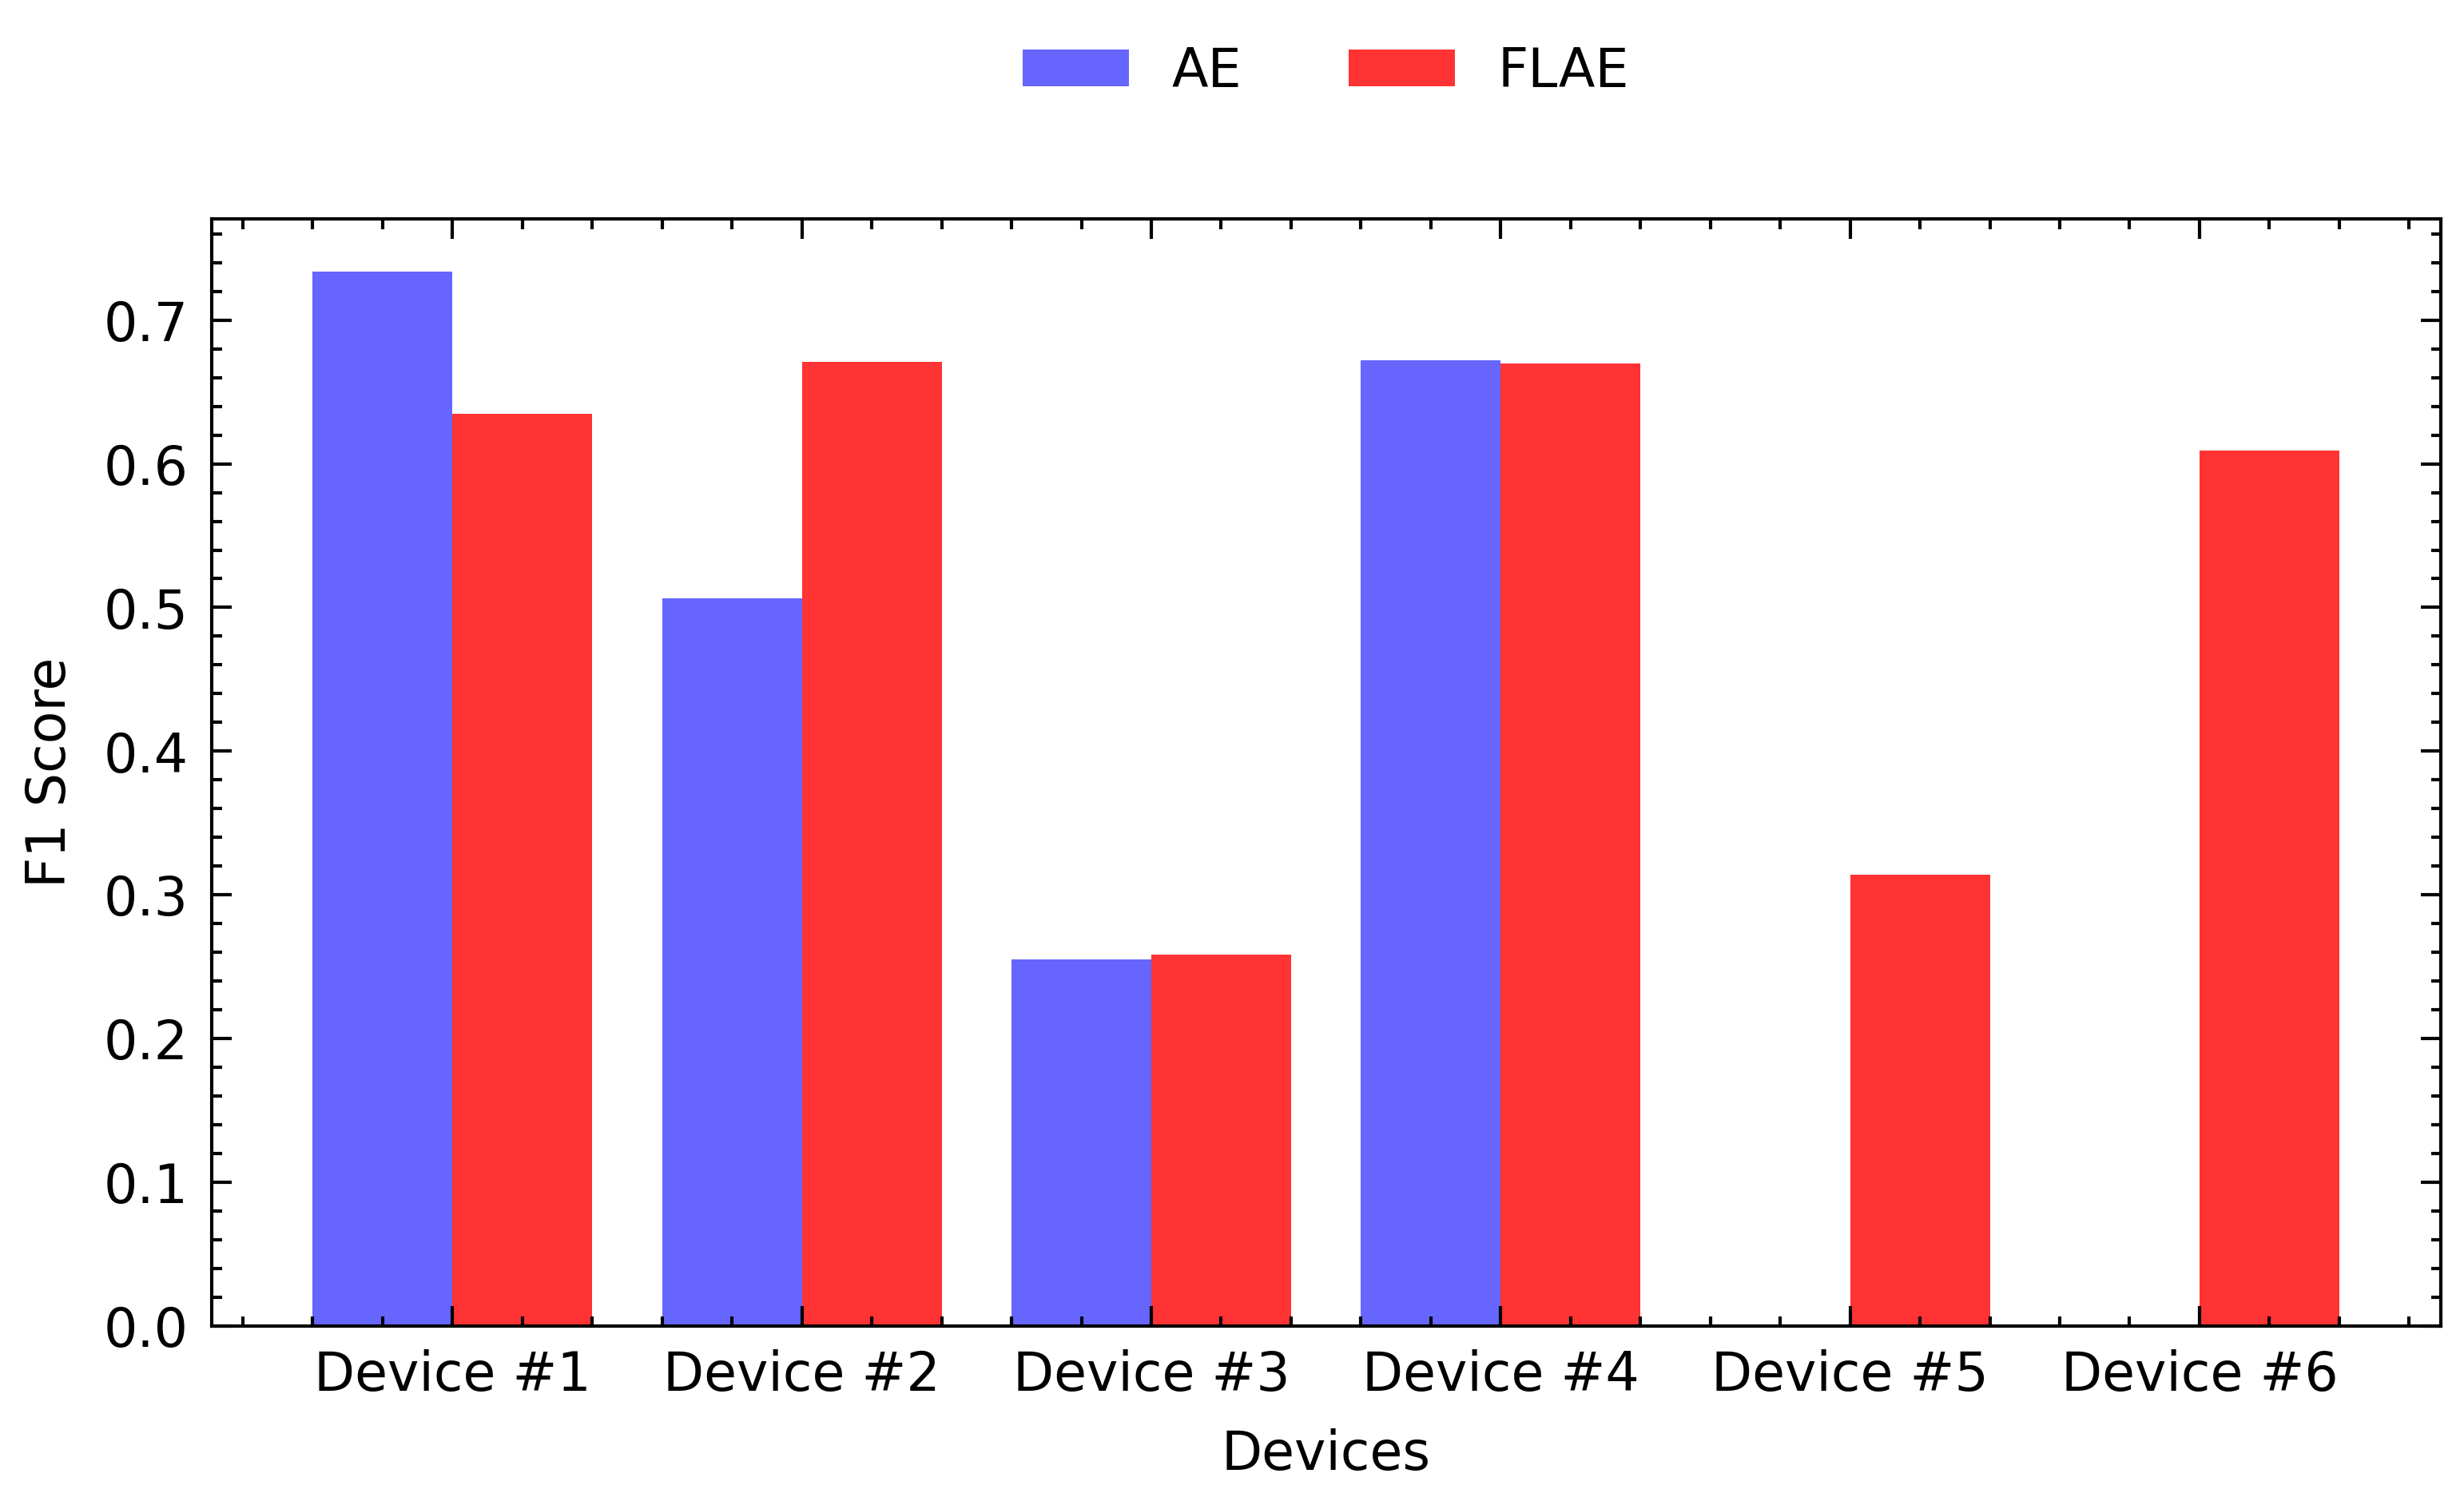

In [355]:
devices = ['Device #1', 'Device #2', 'Device #3', 'Device #4', 'Device #5', 'Device #6']

f1_ae = [0.7341, 0.5066, 0.2552, 0.6719, 0.0, 0.0]
f1_flae = [0.6350, 0.6712, 0.2583, 0.6699, 0.3140, 0.6093]
  
X_axis = np.arange(len(devices))

plt.figure(figsize=(6, 3))
  
plt.bar(X_axis - 0.2, f1_ae, 0.4, color='#6666ff', label = 'AE')
plt.bar(X_axis + 0.2, f1_flae, 0.4, color='#ff3333', label = 'FLAE')
  
plt.xticks(X_axis, devices)
plt.xlabel("Devices")
plt.ylabel("F1 Score")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
plt.show()

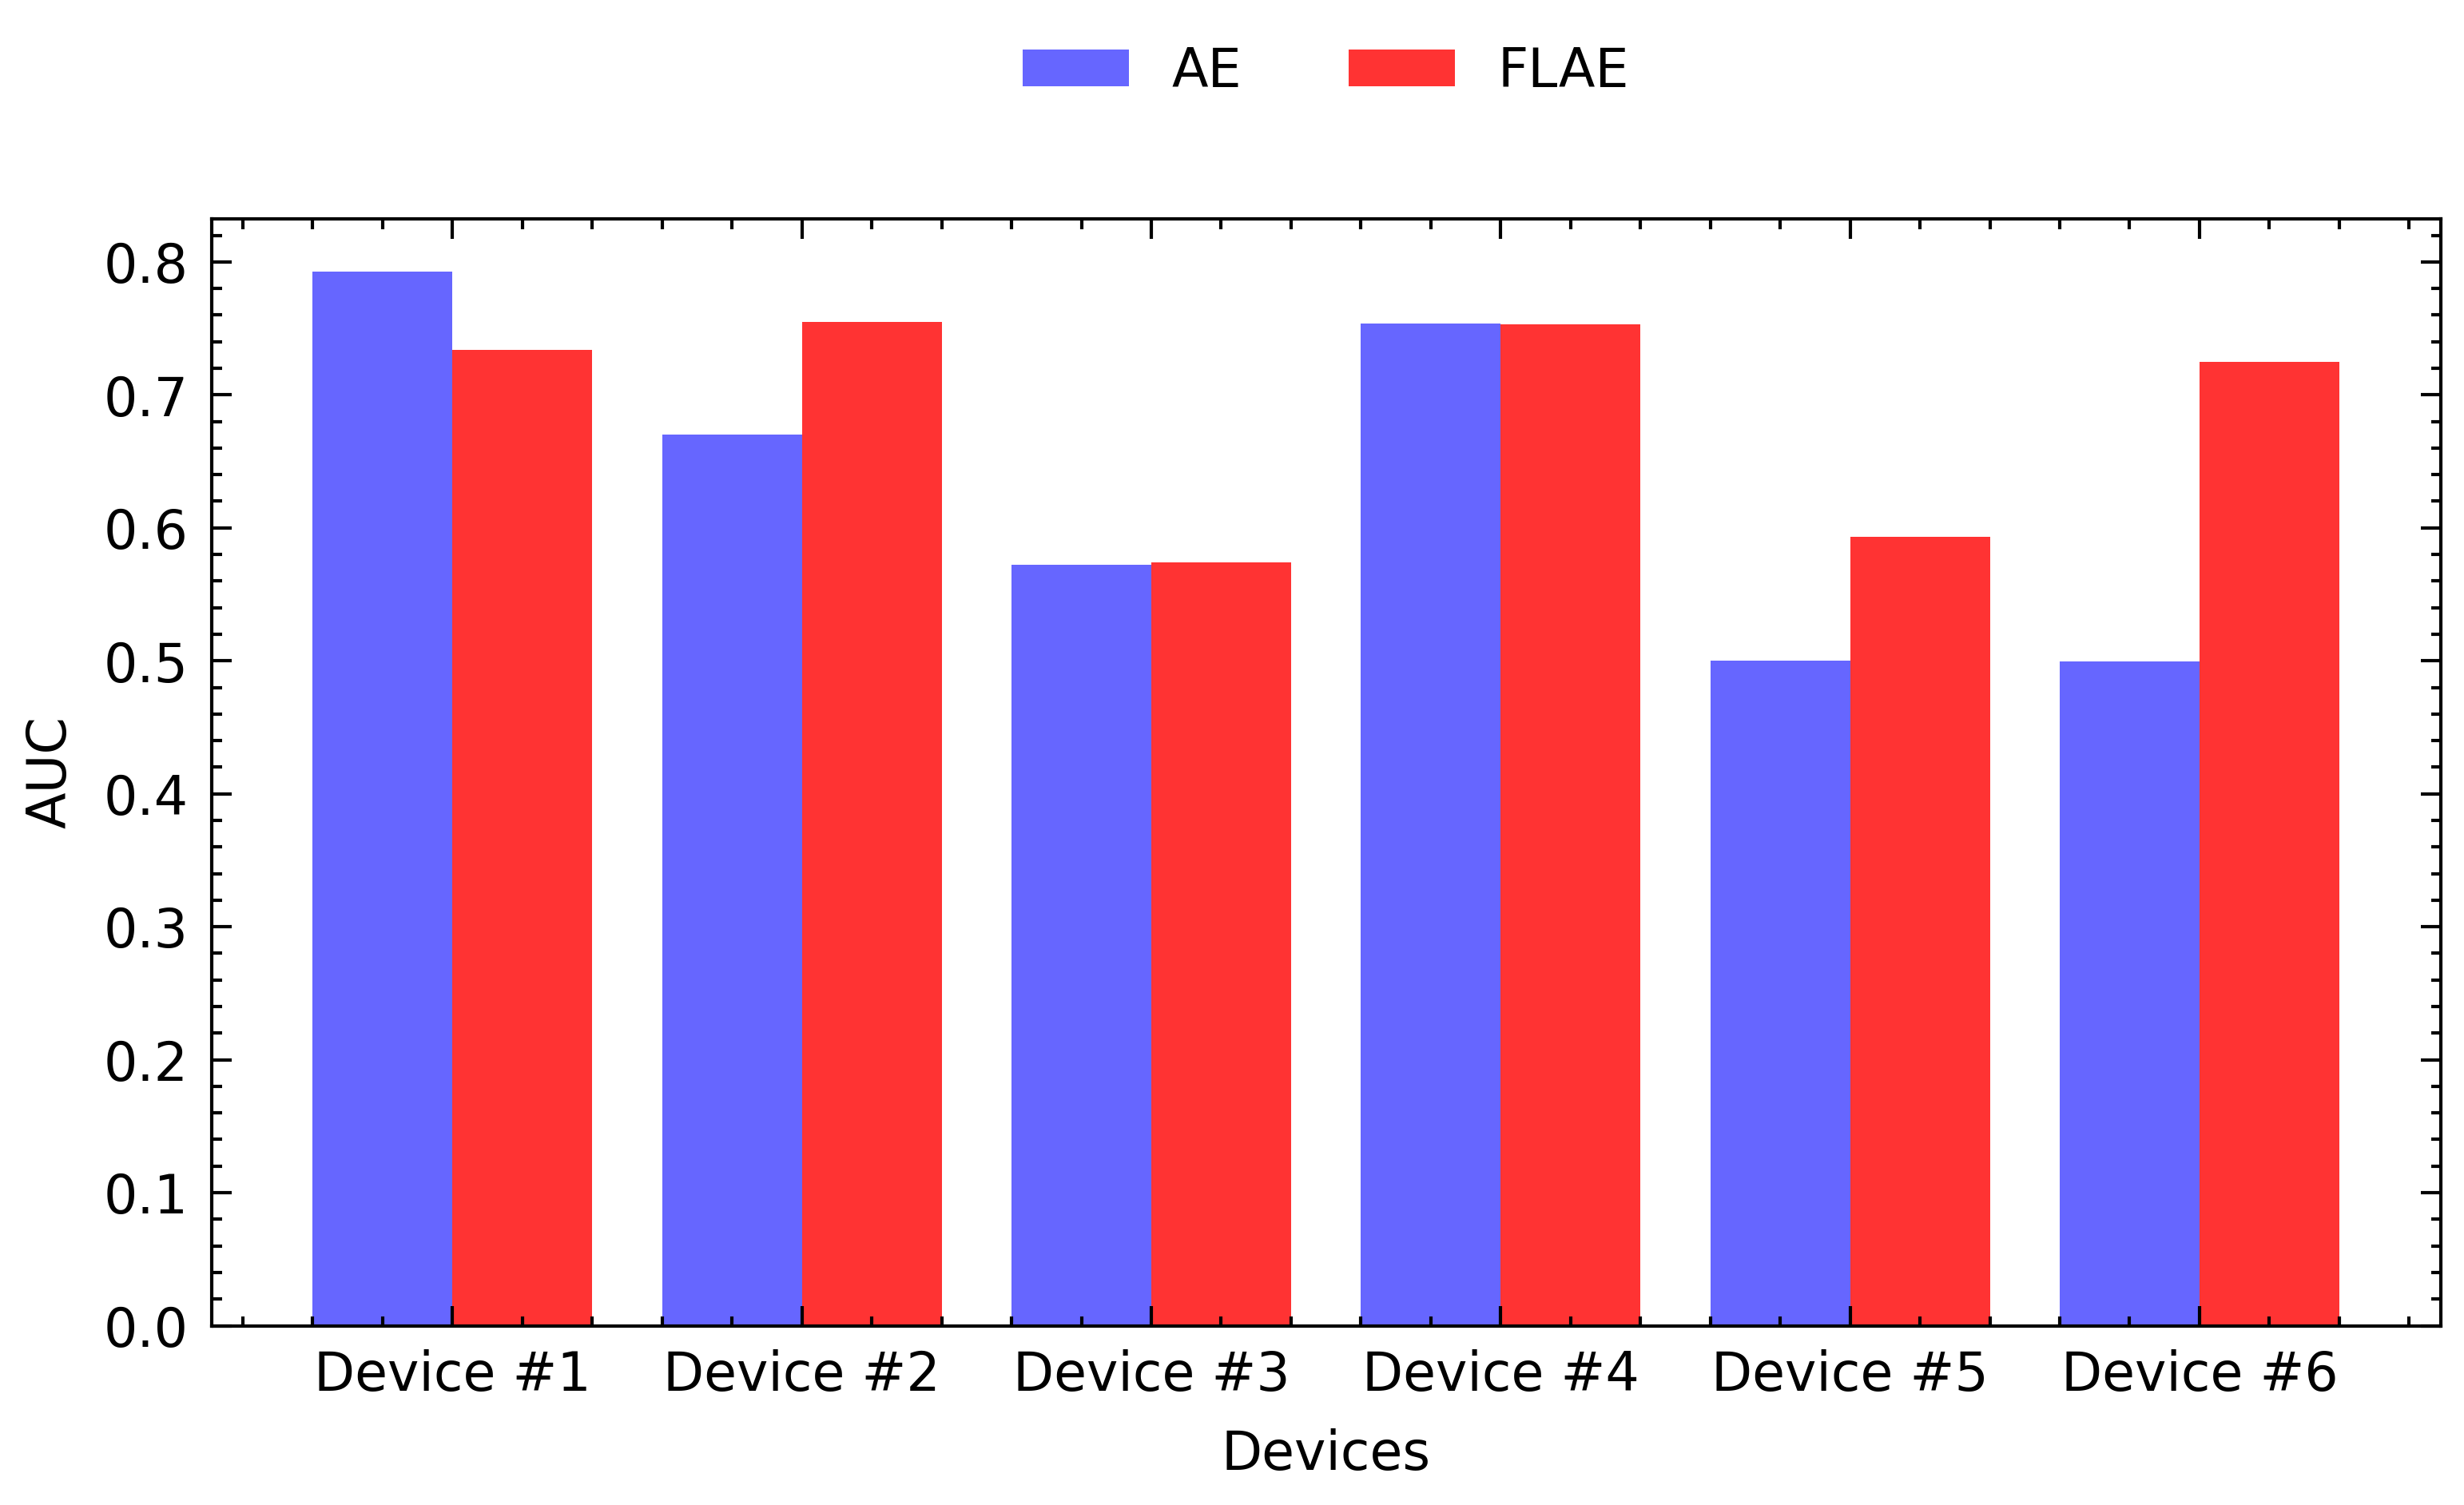

In [356]:
devices = ['Device #1', 'Device #2', 'Device #3', 'Device #4', 'Device #5', 'Device #6']

auc_ae = [0.7930, 0.6700, 0.5720, 0.7534, 0.5, 0.4996]
auc_flae = [0.7339, 0.7549, 0.5741, 0.7529, 0.5931, 0.7246]
  
X_axis = np.arange(len(devices))

plt.figure(figsize=(6, 3))
  
plt.bar(X_axis - 0.2, auc_ae, 0.4, color='#6666ff', label = 'AE')
plt.bar(X_axis + 0.2, auc_flae, 0.4, color='#ff3333', label = 'FLAE')
  
plt.xticks(X_axis, devices)
plt.xlabel("Devices")
plt.ylabel("AUC")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), ncol=2)
plt.show()